logp = -70.111, ||grad|| = 0.0049439: 100%|██████████| 248/248 [00:00<00:00, 264.43it/s] 
/home/hirshs/anaconda3/envs/mars-sunode/lib/python3.7/site-packages/ipykernel_launcher.py:82: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


Initialization
[[ 0.67745872 -0.08466578]
 [-0.09671527 -1.14033485]
 [-0.16558271  0.15817824]
 [-0.09951633  0.11087658]
 [-0.04709275  0.23517823]
 [-0.17829224  0.20845188]]


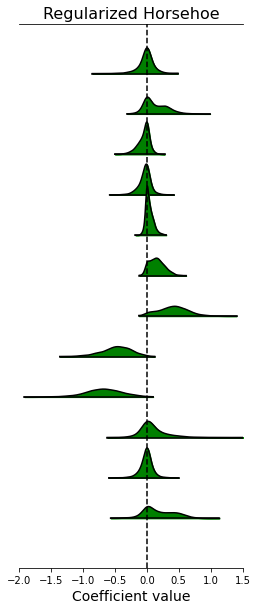

In [1]:
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
import pandas
import sunode.wrappers.as_theano as sun


## Generate Data
df = pandas.read_csv('hudson-bay-linx-hare.csv',header=1)

year = df['Year']
lynx = df['Lynx']
hare = df['Hare']

times = np.array(year,dtype=float)
yobs = np.array([hare,lynx]).T 
yobs_norm = yobs / yobs.std(axis=0)

slab_df = 4
slab_scale = 2

## Do Bayesian Sindy
def predator_prey_sunode_library(t, y, p):
    du_dt = p.pn[0] * y.u + p.pn[2] * y.v + p.pn[4] * y.u * y.v + p.pn[6] * y.u**2 + p.pn[8]* y.v**2 + p.pn[10] - 1e-5 * y.u**3
    dv_dt = p.pn[1] * y.u + p.pn[3] * y.v + p.pn[5] * y.u * y.v + p.pn[7] * y.u**2 + p.pn[9]*y.v**2 + p.pn[11] - 1e-5 * y.v**3
    return {'u': du_dt, 'v' : dv_dt}

model_sunode = pm.Model()

d = 12

with model_sunode:

    sigma = pm.Lognormal('sigma', mu=-1, sigma=0.1, shape=2)
    
    l = pm.HalfStudentT('l', nu=1, sigma=1, shape=d)
    tau = pm.HalfStudentT('tau', nu=1, sigma=0.05)
    c2 = pm.InverseGamma('c2', alpha=0.5*slab_df, beta=0.5*slab_df*slab_scale**2)
    
    lt = (pm.math.sqrt(c2)*l) / pm.math.sqrt(c2 + pm.math.sqr(tau) * pm.math.sqr(l))
    
    z  = pm.Normal('z', mu=0, sigma=1, shape=d)
    pn = pm.Deterministic('pn', z*tau*lt)
    #pn = pm.Normal('pn', mu=0, sigma=tau*l, shape=10)
    
    y0 = pm.Lognormal('y0', mu=pm.math.log(1), sigma=1, shape=2)

    y_hat = sun.solve_ivp(
        y0={
            'u': (y0[0], ()),
            'v': (y0[1], ()),
            },
            params={
                'pn' : (pn,d),
                'tmp': np.zeros(1),  # Theano wants at least one fixed parameter
            },
            rhs=predator_prey_sunode_library,
    make_solver='BDF',
            tvals=times,
            t0=times[0],
        )[0]

    uobs = pm.Lognormal('uobs', mu=pm.math.log(y_hat['u'][:]), sigma=sigma[0], observed=yobs_norm[:,0])
    vobs = pm.Lognormal('vobs', mu=pm.math.log(y_hat['v'][:]), sigma=sigma[1], observed=yobs_norm[:,1])

with model_sunode:
    start = pm.find_MAP()

    # Initialize parameters with least squares and all other values with MAP
    inp = yobs_norm
    u = inp[:,0]
    v = inp[:,1]

    θ = np.array([u,v,u*v,u**2,v**2, np.ones(u.shape)]).T

    import pysindy as ps
    from pysindy.differentiation import SmoothedFiniteDifference
    sfd = SmoothedFiniteDifference(smoother_kws={'window_length': 5})
    dx = sfd(inp)

    guess = np.linalg.lstsq(θ,dx)[0]
    
    print('Initialization')
    print(guess)


    '''start['tau'] = 0.03
    #start['lt'] = (np.sqrt(start['c2'])*start['l']) / np.sqrt(start['c2'] + start['tau']**2 * start['l']**2)
    start['tau_log__'] = np.log(start['tau'])
    start['pn'] = guess.flatten()
    start['z'] = start['pn'] / start['tau'] / start['lt']
    start['z_log__'] = np.log(start['z'])
    start['c2_log__'] = np.log(start['c2'])
    start['l_log__'] = np.log(start['l'])
    start['lt_log__'] = np.log(start['lt'])
    start['y0'] = yobs_norm[0,:]
    start['y0_log__'] = np.log(start['y0'])'''



    #start['pnss'] = start['pn']
    start['tau'] = 0.05
    start['c2'] = 5
    start['l'] = np.ones(start['l'].shape)
    start['sigma'] = 0.1 * np.ones(start['sigma'].shape)
    start['tau_log__'] = np.log(start['tau'])
    start['pn'] = guess.flatten()
    #start['z'] = np.sign(guess).flatten() 
    start['lt'] = (np.sqrt(start['c2'])*start['l']) / np.sqrt(start['c2'] + start['tau']**2 * start['l']**2)
    start['z'] = start['pn'] / start['tau'] / start['lt'] # (np.sqrt(start['c2'])*start['l']) / np.sqrt(start['c2'] + start['tau']**2 * start['l']**2)
    start['c2_log__'] = np.log(start['c2'])
    start['l_log__'] = np.log(start['l'])
    start['lt_log__'] = np.log(start['lt']) 
    start['tau_log__'] = np.log(start['tau'])
    start['y0'] = yobs_norm[0,:]
    start['y0_log__'] = np.log(start['y0'])
    start['sigma_log__'] = np.log(start['sigma'])


    #trace = pm.sample(1000, tune=500, cores=2, random_seed=0, target_accept=0.99, start=start)

    trace = pm.backends.load_trace('real_rh_12param_tau05' + '.trace',model_sunode)

    plt.figure(figsize=(4,10))
    ax = plt.subplot(1,1,1)
    ax.plot([0, 0], [-0.05, 0.5], 'k--')
    pm.forestplot((trace['pn']).T, credible_interval=0.95, kind='ridgeplot', colors='green', ridgeplot_overlap=0.05, ax=ax)
    #ax.set_title('')
    #ax.set_xlabel('Coefficient value')
    #ax.set_ylabel('Coefficient')
    ax.set_xlim(-2, 1.5)
    ax.set_ylim(-0.05, 0.5)
    #ax.set_yticks(np.array([0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55]) * 0.85)
    #ax.set_yticklabels([ r'$\dot{u} \ \colon \ u$', r'$\dot{v} \ \colon \ u$',
    #                    r'$\dot{u} \ \colon \ v$', r'$\dot{v} \ \colon \ v$',
    #                    r'$\dot{u} \ \colon \ u v$', r'$\dot{v} \ \colon \ u v$',
    #                    r'$\dot{u} \ \colon \ u^2$', r'$\dot{v} \ \colon \ u^2$',
    #                    r'$\dot{u} \ \colon \ v^2$', r'$\dot{v} \ \colon \ v^2$',
    #                    r'$\dot{v} \ \colon \ 1$', r'$\dot{u} \ \colon \ 1$'], fontsize=16)

    ax.set_xlabel('Coefficient value', fontsize=14)
    plt.title('Regularized Horsehoe', fontsize=16)
    plt.yticks([])    
    plt.show()

In [2]:
pm.summary(trace)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
z[0],0.569,0.905,-1.332,2.150,0.104,0.074,75.0,75.0,84.0,114.0,1.01
z[1],-0.004,0.874,-1.569,1.777,0.081,0.058,116.0,116.0,121.0,205.0,1.04
z[2],0.327,0.864,-1.380,1.901,0.096,0.068,81.0,81.0,82.0,142.0,1.02
z[3],-1.158,0.612,-2.319,-0.181,0.053,0.038,131.0,131.0,131.0,249.0,1.00
z[4],-1.036,0.582,-2.104,-0.139,0.050,0.035,137.0,137.0,133.0,336.0,1.00
z[5],0.951,0.613,0.104,2.289,0.053,0.038,133.0,133.0,136.0,105.0,1.02
z[6],0.771,0.645,-0.362,2.147,0.052,0.036,157.0,157.0,150.0,87.0,1.02
z[7],0.405,0.743,-1.011,1.884,0.110,0.079,45.0,45.0,45.0,79.0,1.05
z[8],-0.268,0.804,-1.770,1.437,0.085,0.060,89.0,89.0,88.0,239.0,1.02
z[9],-0.299,0.879,-1.982,1.367,0.104,0.074,71.0,71.0,72.0,81.0,1.02
